Домашнее задание:

    К вам приходит руководитель продукта “Интернет-магазин”
    И спрашивает про удержание клиентов и повторные покупки
    У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали больше оттекать пользователи
    Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году? 

Данные лежат в папке занятия на сервере:

    есть транзакции (покупки) в интернет магазине, в том числе id клиента, id покупки, timestamp покупки и тп
    orders.csv, customers.csv

Ваши задачи: 

    Проверить гипотезу руководителя продукта 
    Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы


In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
customers = pd.read_csv("customers.csv")
orders = pd.read_csv("orders.csv")

In [3]:
customers.head()

,id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord


In [4]:
orders.head()

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376


In [5]:
df = pd.merge(orders, customers, how = 'left', left_on = 'customer_id', right_on = 'id')

In [6]:
df.head()

,id_x,order_date,ship_mode,customer_id,sales,id_y,name,segment,state,city
0,100006,2014-09-07,Standard,DK-13375,377.970,DK-13375,Dennis Kane,Consumer,Ohio,Marion
1,100090,2014-07-08,Standard,EB-13705,699.192,EB-13705,Ed Braxton,Corporate,Ohio,Akron
2,100293,2014-03-14,Standard,NF-18475,91.056,NF-18475,Neil Franzosisch,Home Office,Illinois,Rockford
3,100328,2014-01-28,Standard,JC-15340,3.928,JC-15340,Jasper Cacioppo,Consumer,California,Los Angeles
4,100363,2014-04-08,Standard,JM-15655,21.376,JM-15655,Jim Mitchum,Corporate,New Jersey,Bridgeton


In [7]:
df['order_date'] = pd.to_datetime(df['order_date'],infer_datetime_format=True)
df['order_month'] = df['order_date'].dt.strftime('%Y-%m') 

In [8]:
cohorts = df.groupby('customer_id',as_index=False)['order_month'].min()
cohorts.rename(columns = {'order_month':'cohort'},inplace=True)
cohorts.head()

,customer_id,cohort
0,AA-10315,2014-03
1,AA-10375,2014-04
2,AA-10480,2014-05
3,AA-10645,2014-06
4,AB-10015,2014-02


In [9]:
df_merged = pd.merge(df, cohorts , how='left', on='customer_id')
df_merged.head()

,id_x,order_date,ship_mode,customer_id,sales,id_y,name,segment,state,city,order_month,cohort
0,100006,2014-09-07,Standard,DK-13375,377.970,DK-13375,Dennis Kane,Consumer,Ohio,Marion,2014-09,2014-09
1,100090,2014-07-08,Standard,EB-13705,699.192,EB-13705,Ed Braxton,Corporate,Ohio,Akron,2014-07,2014-07
2,100293,2014-03-14,Standard,NF-18475,91.056,NF-18475,Neil Franzosisch,Home Office,Illinois,Rockford,2014-03,2014-03
3,100328,2014-01-28,Standard,JC-15340,3.928,JC-15340,Jasper Cacioppo,Consumer,California,Los Angeles,2014-01,2014-01
4,100363,2014-04-08,Standard,JM-15655,21.376,JM-15655,Jim Mitchum,Corporate,New Jersey,Bridgeton,2014-04,2014-04


Прежде всего, посмотрим на retention в 2014-2015

In [10]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['cohort_period'] = np.arange(len(df))
    return df

In [11]:
df_last = df_merged[(df_merged['order_month'] < '2016-01') & (df_merged['cohort'] < '2016-01')]

In [12]:
def get_retention(df):
  cohorts_group = df.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
  cohorts_group.rename(columns={'customer_id': 'total_users', 'id': 'total_orders'}, inplace=True)
  cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
  cohorts_group.reset_index(inplace=True)
  cohorts_group.set_index(['cohort', 'cohort_period'], inplace=True) 
  cohort_group_size = cohorts_group['total_users'].groupby(level=0).first()
  user_retention = cohorts_group['total_users'].unstack(0).divide(cohort_group_size, axis=1)
  return user_retention

def print_rentention(user_retention, s):
  sns.set(style='white')
  plt.figure(figsize=(16, 10))
  plt.title(s)
  sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

In [13]:
user_retention = get_retention(df_last) 

In [14]:
user_retention.T

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
cohort,,,,,,,,,,,,,,,,,,,,,
2014-01,1.0,0.093750,0.062500,0.062500,0.062500,0.125000,0.156250,0.093750,0.218750,0.156250,0.093750,0.093750,0.093750,0.093750,0.125000,0.093750,0.062500,0.125000,0.187500,0.156250,NaN
2014-02,1.0,0.166667,0.083333,0.041667,0.083333,0.083333,0.125000,0.125000,0.166667,0.166667,0.041667,0.083333,0.083333,0.083333,0.083333,0.125000,0.250000,0.083333,0.125000,0.083333,NaN
2014-03,1.0,0.061538,0.030769,0.123077,0.107692,0.107692,0.076923,0.123077,0.092308,0.015385,0.030769,0.092308,0.046154,0.076923,0.076923,0.046154,0.076923,0.138462,0.169231,0.200000,0.184615
2014-04,1.0,0.107143,0.035714,0.071429,0.053571,0.142857,0.107143,0.160714,0.142857,0.017857,0.071429,0.089286,0.142857,0.178571,0.107143,0.089286,0.107143,0.160714,0.053571,0.250000,0.196429
2014-05,1.0,0.089286,0.089286,0.071429,0.178571,0.035714,0.214286,0.178571,0.071429,0.053571,0.071429,0.125000,0.035714,0.089286,0.035714,0.089286,0.142857,0.107143,0.196429,0.142857,NaN
2014-06,1.0,0.020833,0.041667,0.083333,0.041667,0.187500,0.166667,0.020833,0.083333,0.125000,0.104167,0.104167,0.062500,0.083333,0.145833,0.104167,0.145833,0.333333,0.187500,NaN,NaN
2014-07,1.0,0.136364,0.113636,0.113636,0.181818,0.045455,0.181818,0.045455,0.159091,0.159091,0.113636,0.113636,0.090909,0.136364,0.159091,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,1.0,0.163265,0.061224,0.224490,0.102041,0.061224,0.081633,0.040816,0.081633,0.061224,0.102041,0.122449,0.040816,0.183673,0.122449,0.163265,0.265306,NaN,NaN,NaN,NaN
2014-09,1.0,0.132353,0.132353,0.161765,0.014706,0.029412,0.132353,0.147059,0.132353,0.029412,0.088235,0.117647,0.176471,0.088235,0.191176,0.220588,NaN,NaN,NaN,NaN,NaN


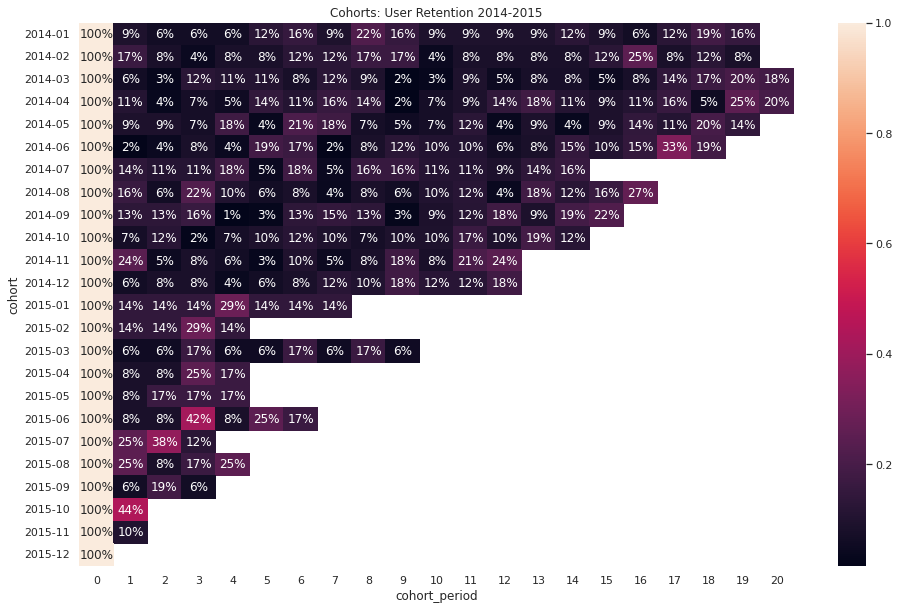

In [15]:
print_rentention(user_retention, 'Cohorts: User Retention 2014-2015')

Теперь посмотрим на retention в 2016-2017

In [26]:
df_next = df_merged[(df_merged['order_month'] >= '2016-01') & (df_merged['cohort'] >= '2016-01')]

In [27]:
user_retention = get_retention(df_next) 

In [28]:
user_retention.T

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
cohort,,,,,,,,,,,,,,,,,,
2016-01,1.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.333333,0.333333,0.333333,0.333333,0.333333,0.166667,0.333333,NaN
2016-02,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03,1.0,0.500000,0.500000,0.166667,0.166667,0.166667,0.166667,0.500000,0.166667,0.166667,0.333333,0.333333,0.166667,0.166667,0.166667,0.166667,0.666667,0.333333
2016-04,1.0,0.285714,0.142857,0.142857,0.571429,0.142857,0.285714,0.142857,0.142857,0.285714,0.285714,0.142857,0.142857,0.285714,NaN,NaN,NaN,NaN
2016-05,1.0,0.142857,0.285714,0.142857,0.142857,0.285714,0.142857,0.285714,0.142857,0.285714,0.142857,0.142857,0.285714,0.285714,0.142857,0.285714,0.285714,NaN
2016-06,1.0,0.125000,0.250000,0.375000,0.125000,0.125000,0.125000,0.125000,0.250000,0.250000,0.250000,0.375000,0.125000,0.375000,NaN,NaN,NaN,NaN
2016-07,1.0,0.500000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1.0,0.250000,0.250000,0.500000,0.500000,0.250000,0.250000,0.500000,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


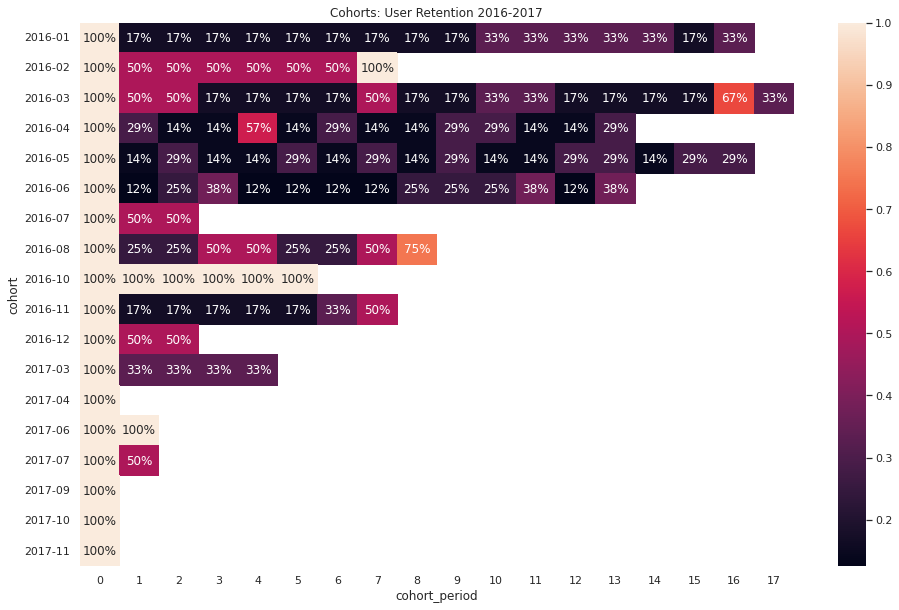

In [29]:
print_rentention(user_retention, 'Cohorts: User Retention 2016-2017')

Можно заметить, что retention с течением времени не падает, а скорее даже растет. Самый хороший retention был в 2016-10. При этом в 2017 ретеншн упал.

Посмотрим на retention в группах с разным типом доставки. Для начала рассмотрим тип Standart.

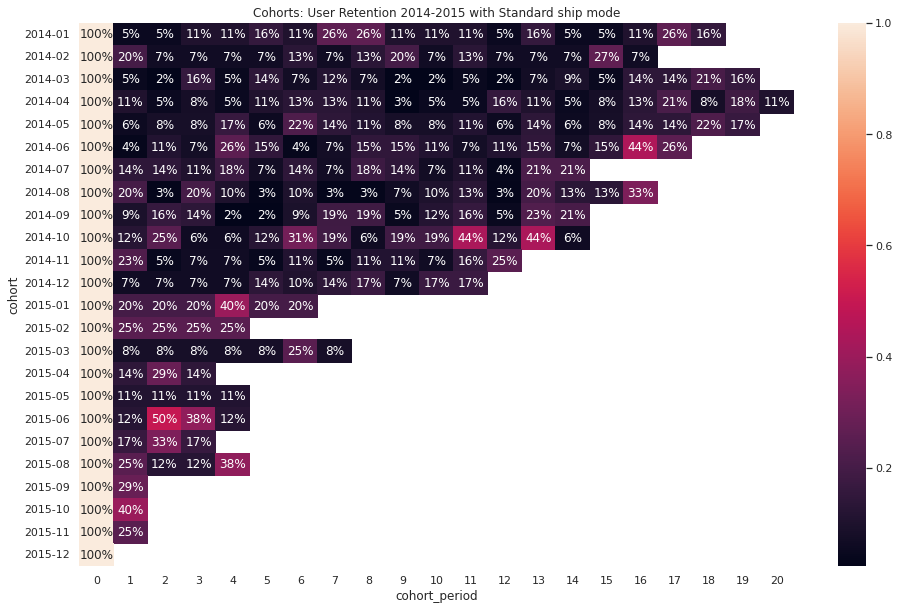

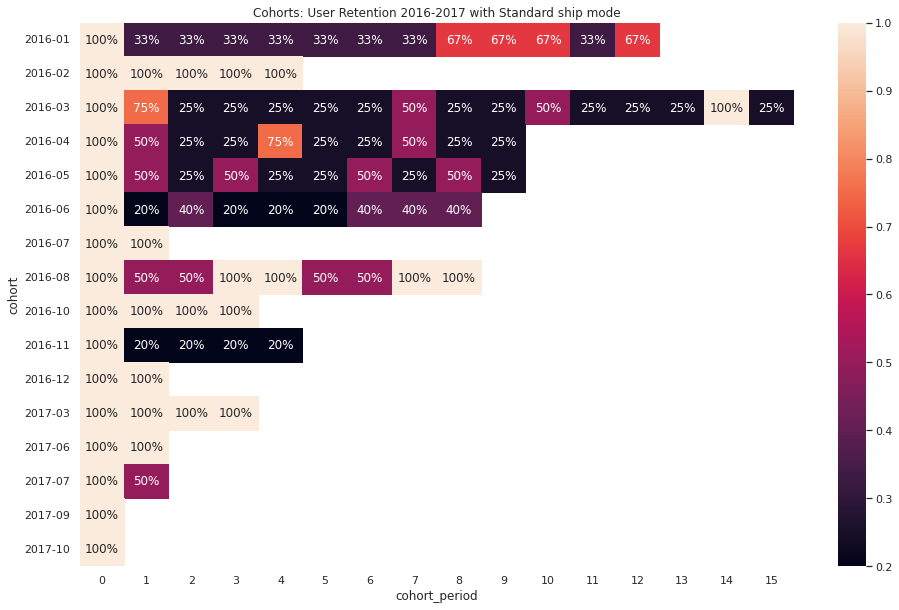

In [39]:
df_standart_last = df_merged[(df_merged['ship_mode'] == 'Standard') & (df_merged['order_month'] < '2016-01') & (df_merged['cohort'] < '2016-01')]
df_standart_next = df_merged[(df_merged['ship_mode'] == 'Standard') & (df_merged['order_month'] >= '2016-01') & (df_merged['cohort'] >= '2016-01')]

user_retention_last = get_retention(df_standart_last) 
user_retention_next = get_retention(df_standart_next) 

print_rentention(user_retention_last, 'Cohorts: User Retention 2014-2015 with Standard ship mode')
print_rentention(user_retention_next, 'Cohorts: User Retention 2016-2017 with Standard ship mode')

Наблюдаем ситуацию, аналогичную общему случаю, когда с течением времени retention растет. Но в 2017 году падает.

Теперь исследуем аналогичным образом остальные типы доставки. Рассмотрим тип Same Day

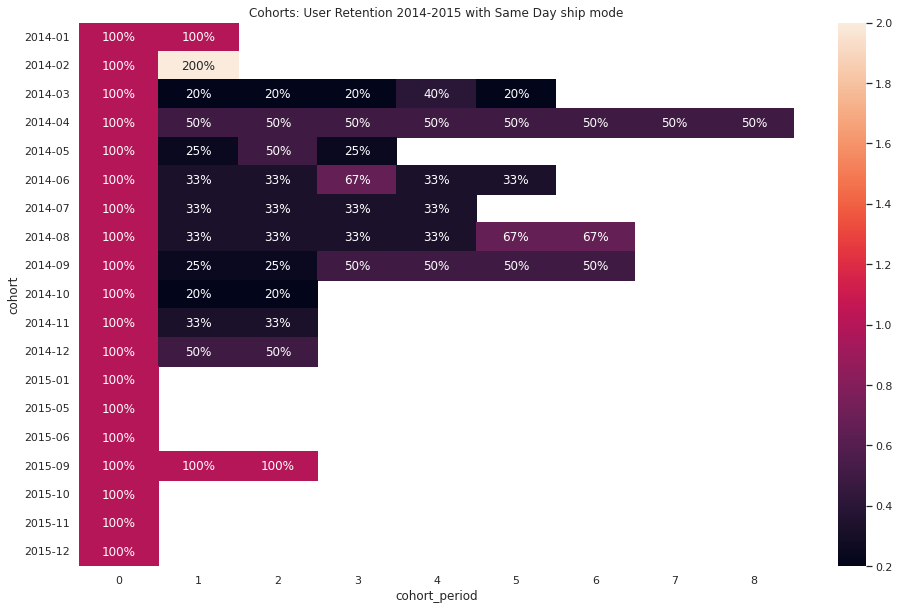

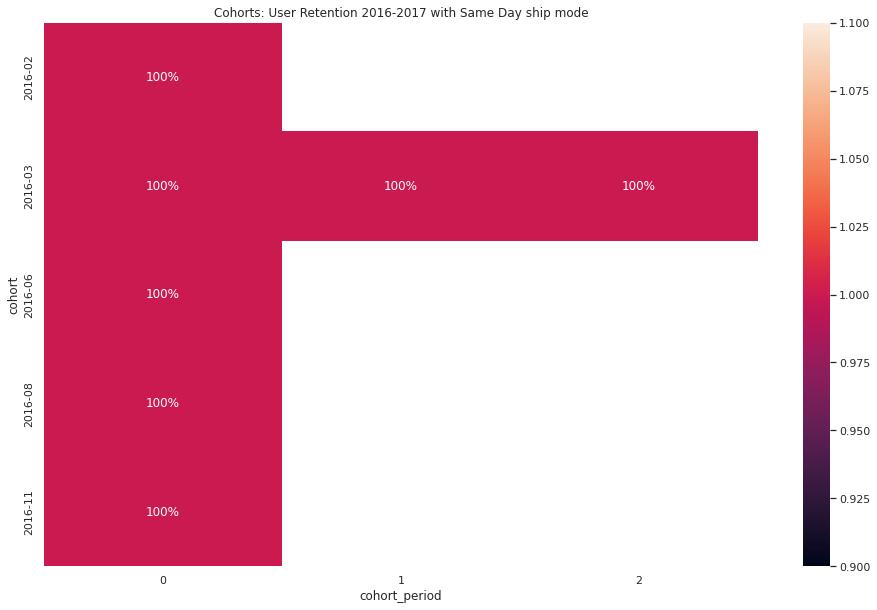

In [40]:
df_last = df_merged[(df_merged['ship_mode'] == 'Same Day') & (df_merged['order_month'] < '2016-01') & (df_merged['cohort'] < '2016-01')]
df_next = df_merged[(df_merged['ship_mode'] == 'Same Day') & (df_merged['order_month'] >= '2016-01') & (df_merged['cohort'] >= '2016-01')]

user_retention_last = get_retention(df_last) 
user_retention_next = get_retention(df_next) 

print_rentention(user_retention_last, 'Cohorts: User Retention 2014-2015 with Same Day ship mode')
print_rentention(user_retention_next, 'Cohorts: User Retention 2016-2017 with Same Day ship mode')

Можно заметить, что в случае доставки "Same day" наблюдается ситуация, когда ретеншн упал начиная с 2015 года. Но часть пользователей возвращались в 2015-2016 годах. При жтом начиная с 2017 года заказов не было вообще.

Теперь рассмотрим тип доставки First

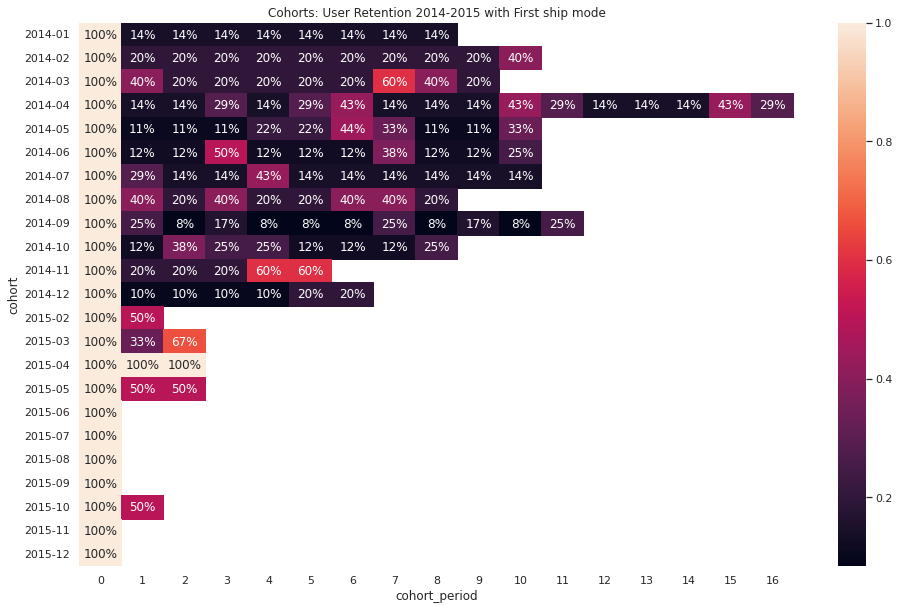

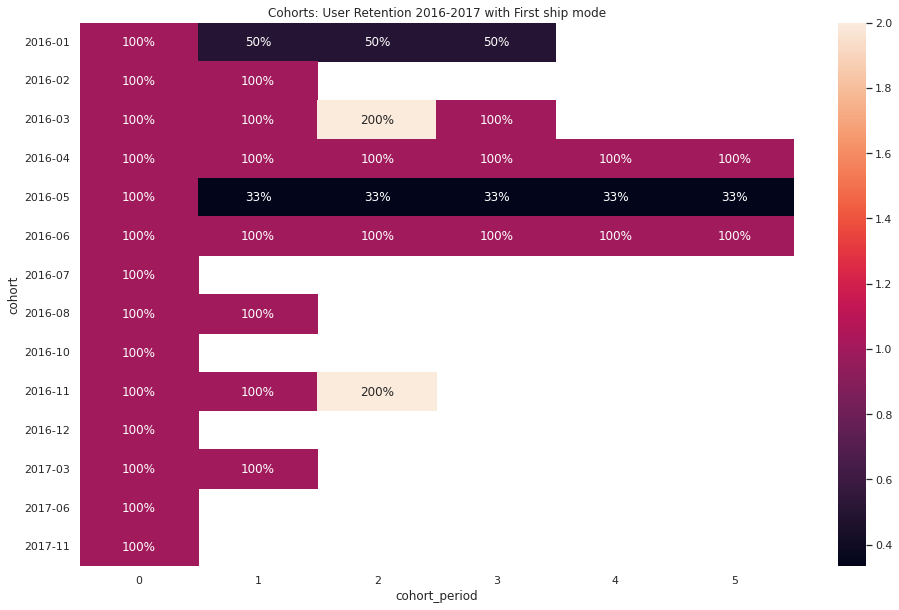

In [41]:
df_last = df_merged[(df_merged['ship_mode'] == 'First') & (df_merged['order_month'] < '2016-01') & (df_merged['cohort'] < '2016-01')]
df_next = df_merged[(df_merged['ship_mode'] == 'First') & (df_merged['order_month'] >= '2016-01') & (df_merged['cohort'] >= '2016-01')]

user_retention_last = get_retention(df_last) 
user_retention_next = get_retention(df_next) 

print_rentention(user_retention_last, 'Cohorts: User Retention 2014-2015 with First ship mode')
print_rentention(user_retention_next, 'Cohorts: User Retention 2016-2017 with First ship mode')

Здесь видим, что ретеншн вырос в 2016 году. Но при этом в конце 2016 упал и был маленький в 2017 году.

Рассмотрим тип доставки Second

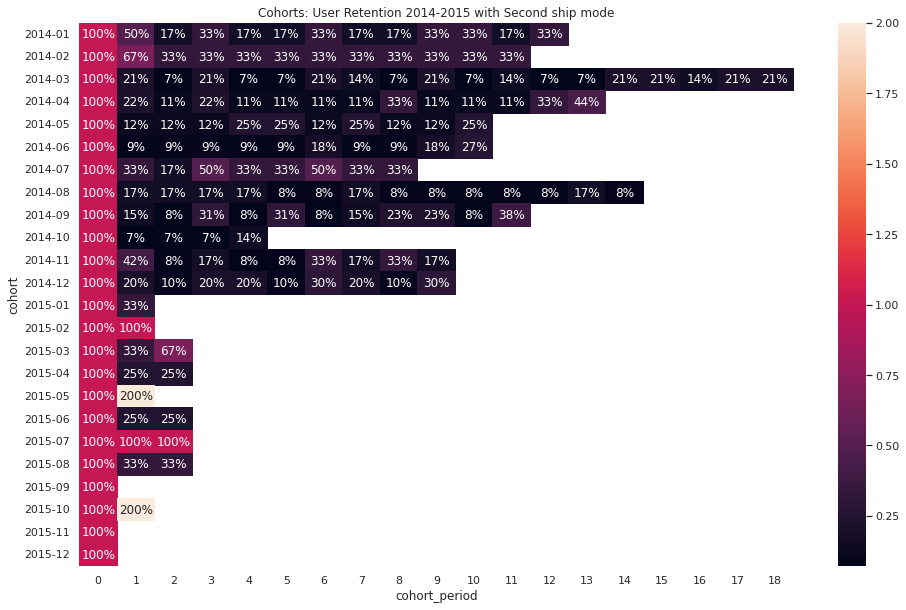

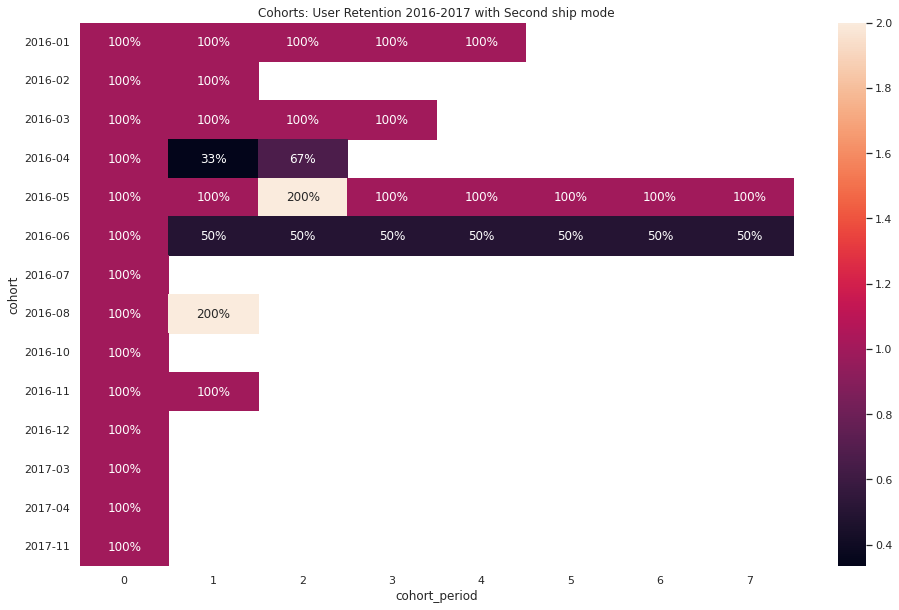

In [42]:
df_last = df_merged[(df_merged['ship_mode'] == 'Second') & (df_merged['order_month'] < '2016-01') & (df_merged['cohort'] < '2016-01')]
df_next = df_merged[(df_merged['ship_mode'] == 'Second') & (df_merged['order_month'] >= '2016-01') & (df_merged['cohort'] >= '2016-01')]

user_retention_last = get_retention(df_last) 
user_retention_next = get_retention(df_next) 

print_rentention(user_retention_last, 'Cohorts: User Retention 2014-2015 with Second ship mode')
print_rentention(user_retention_next, 'Cohorts: User Retention 2016-2017 with Second ship mode')

Здесь видим, аналогичную ситуацию, ретеншн вырос в 2016 году. Но при этом в конце 2016 упал и был маленький в 2017 году.

Можно сделать вывод о том, что в целом отток пользователей был в 2017 году. При этом ситуация немного меняется при рассмотрении различных способов доставки (в каких-то случаях ретеншн упал незначительно и даже вырос у постоянных клиентов, а при других способах доставки заказов в 2017 году не было вообще)